# 미니 프로젝트 : 주식 예측

ARIMA 를 통해 주식값 예측하는 과정을 진행해보자. [Yahoo Finance](https://finance.yahoo.com/quote/005930.KS?p=005930.KS&.tsrc=fin-srch)에 있는 삼성전자에 대한 주식 시세를 예측해보자.  


![image](https://user-images.githubusercontent.com/84179578/132287489-f54fda3c-ef1b-41b9-add4-bfa42750b667.png)

## 1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 데이터 불러오기 
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


- 칼럼 종류: `Date`, `Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있음
- 종가(Close)만 사용. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격)

In [2]:
# Time Series 생성
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

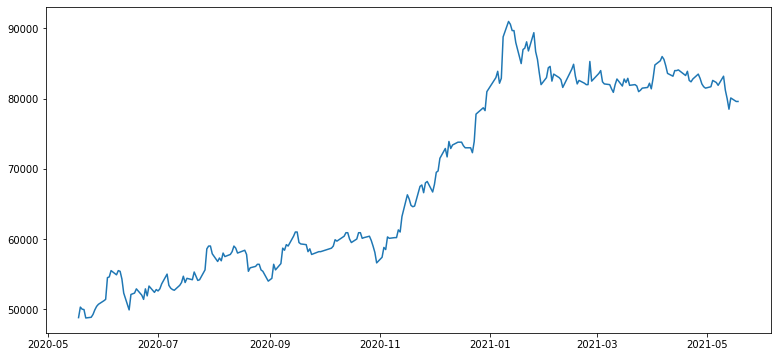

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

----
## 2. 데이터 전처리
### 결측치 처리

In [4]:
# 결측치 처리
ts=ts.interpolate(method='time')
# Time Series에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

### 로그 변환

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

----
## 3. 시계열 안정성 분석

### 정성적 그래프 분석

일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수를 구현한다.

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

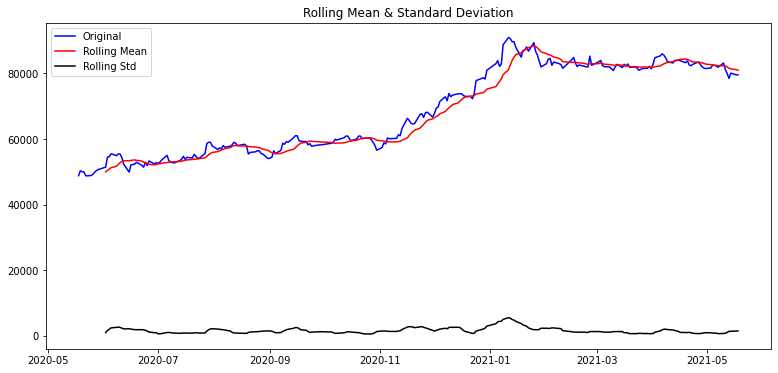

In [7]:
plot_rolling_statistics(ts, window=12)

### Augmented Dickey-Fuller Test

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Augmented Dickey-Fuller Test의 결과 p-value는 0.59 수준이어서 안정적 시계열이라고 말 할 수 없다.

### Stationary 하게 만들기 - 시계열 분해

`statsmodels` 라이브러리 안에는 `seasonal_decompose` 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있다.  
이 기능을 활용하면  moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 된다.

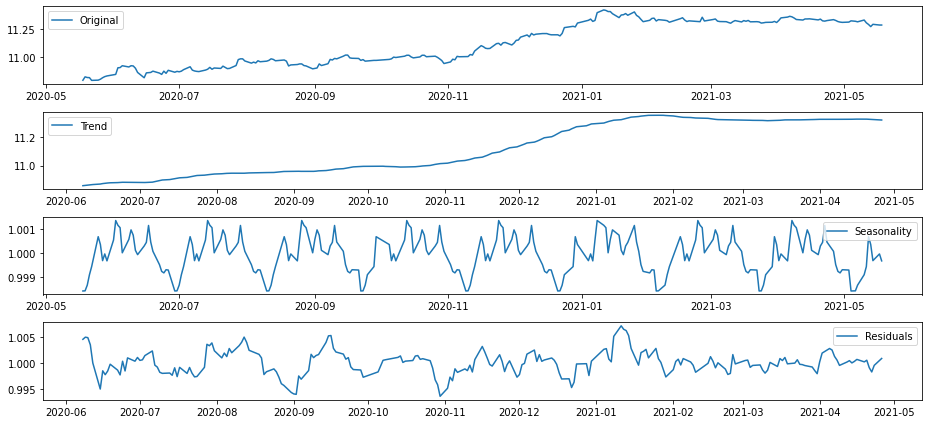

In [10]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

In [11]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여준다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

----
## 4. 학습, 테스트 데이터셋 생성
학습 데이터와 테스트 데이터를 분리한다.  
분리 비율은 학습과 테스트에 9:1로 하겠다. 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당할 것이다.

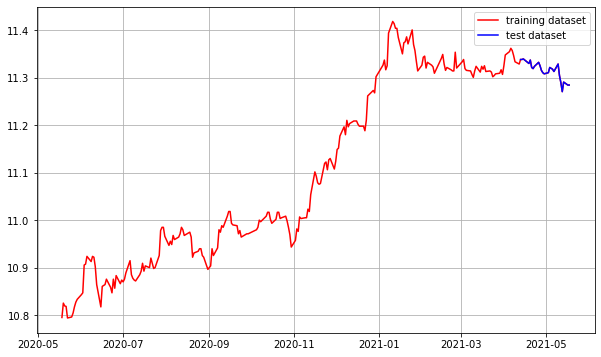

In [12]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

----
## 5. 적정 ARIMA 모수 찾기

### ACF와 PACF 플로팅

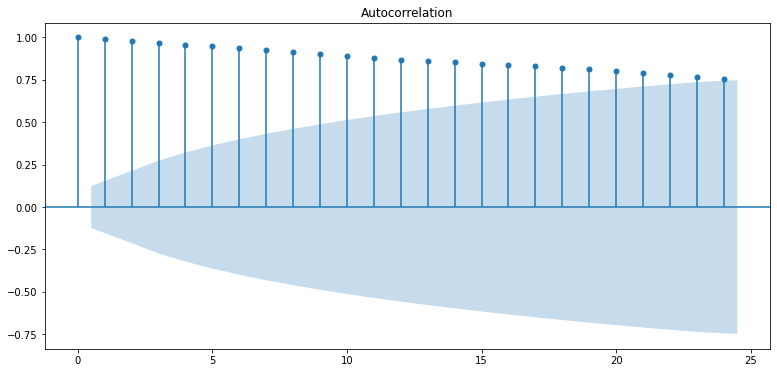

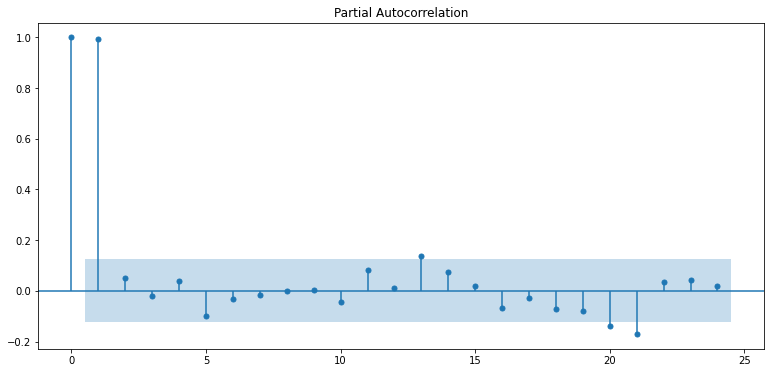

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있다.

||$AR(p)$|$MA(q)$|
|:----:|:----:|:----:|
|ACF|점차적으로 감소|시차 $q$ 이후에 0|
|PACF|시차 $p$ 이후에 0|점차적으로 감소|


- 이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합
  - p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문
  - PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻
  
- ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다.
- q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠다.  


d 를 구하기 위해서는 좀 다른 접근이 필요하다. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해보자.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


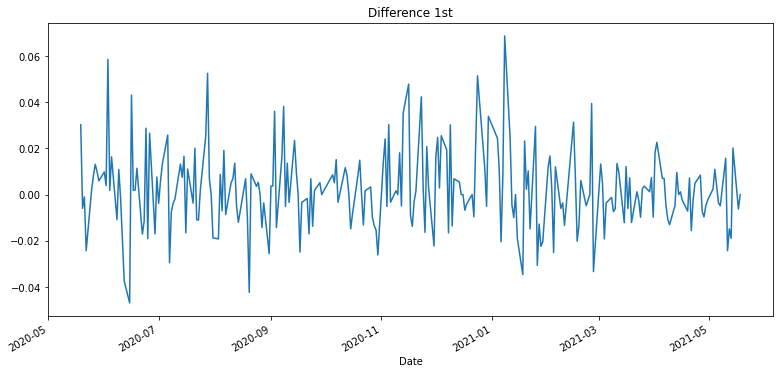

In [14]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

----
## 6. ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1164.792
Time:                        07:58:01   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

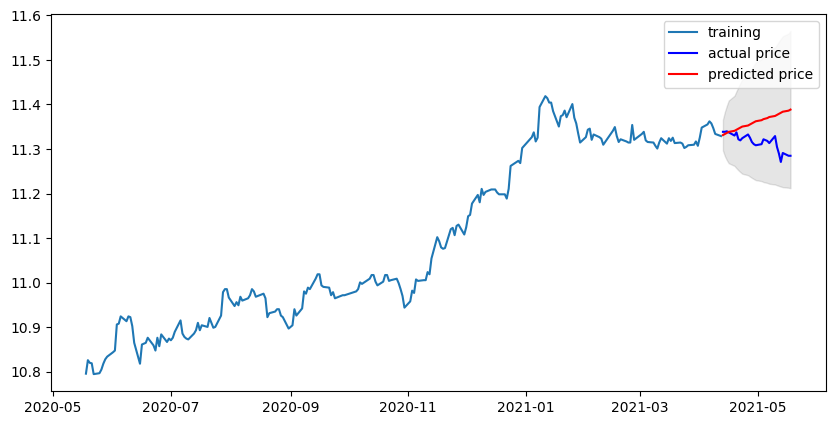

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


----
#  다른 주식 종목 예측

또 다른 주식 종목도 위와 같은 과정으로 예측해보자.  

예시로 애플의 주식 데이터를 이용해 예측을 해보자.

## 1. 시계열 데이터 준비

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 데이터 불러오기 
dataset_filepath = 'EP14_data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-08,113.949997,118.989998,112.680000,112.820000,112.098999,231366600
2020-09-09,117.260002,119.139999,115.260002,117.320000,116.570236,176940500
2020-09-10,120.360001,120.500000,112.500000,113.489998,112.764717,182274400
2020-09-11,114.570000,115.230003,110.000000,112.000000,111.284241,180860300
2020-09-14,114.720001,115.930000,112.800003,115.360001,114.622765,140150100
...,...,...,...,...,...,...
2021-08-30,149.000000,153.490005,148.610001,153.119995,153.119995,90956700
2021-08-31,152.660004,152.800003,151.289993,151.830002,151.830002,86453100
2021-09-01,152.830002,154.979996,152.339996,152.509995,152.509995,80313700


In [20]:
# Time Series 생성
ts = df['Close']

ts.head()

Date
2020-09-08    112.820000
2020-09-09    117.320000
2020-09-10    113.489998
2020-09-11    112.000000
2020-09-14    115.360001
Name: Close, dtype: float64

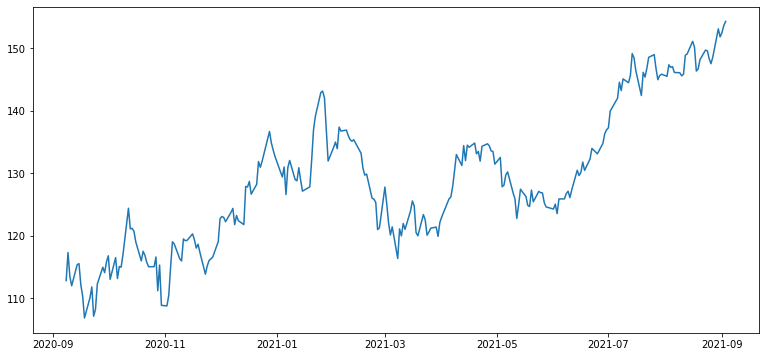

In [21]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## 2. 데이터 전처리

In [22]:
# 결측치 처리
ts=ts.interpolate(method='time')
# Time Series에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [23]:
# 로그 변환 시도 
ts_log = np.log(ts)

## 3. 시계열 안정성 분석

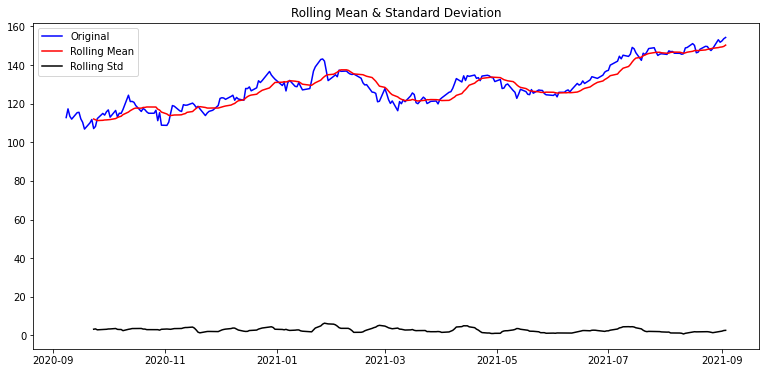

In [24]:
plot_rolling_statistics(ts, window=12)

In [25]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.964137
p-value                          0.766119
#Lags Used                       1.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


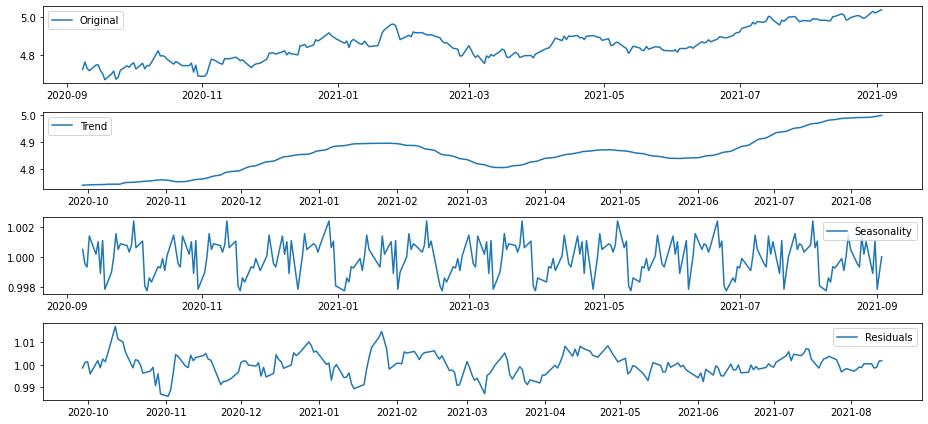

In [26]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.416770
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여준다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

## 4. 학습,테스트 데이터셋 생성

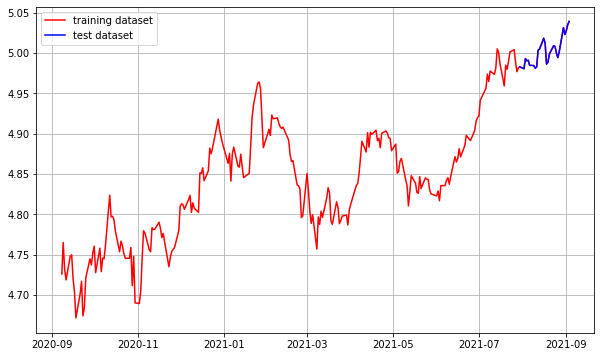

In [28]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

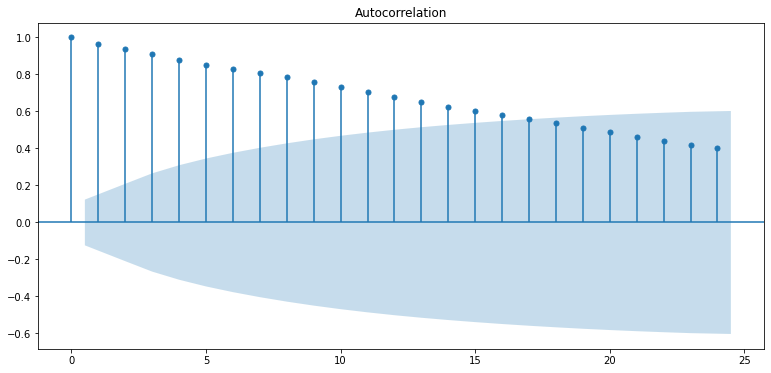

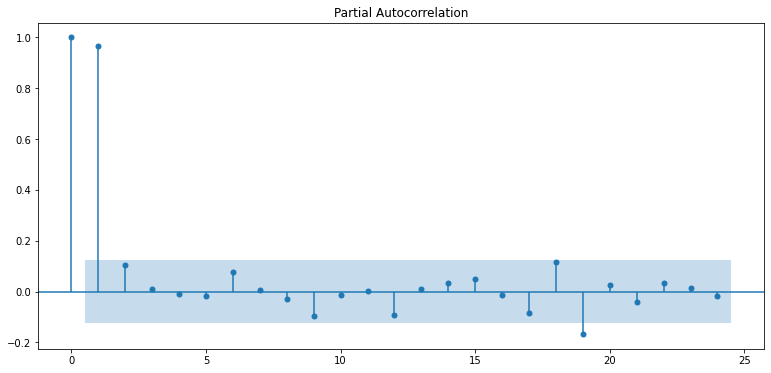

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.773999e+01
p-value                        3.405496e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


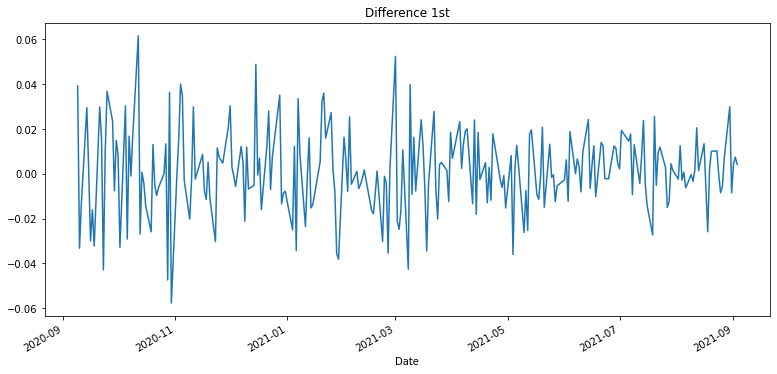

In [30]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

----
## 6. ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

In [32]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 569.835
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 07 Sep 2021   AIC                          -1133.670
Time:                        08:25:04   BIC                          -1123.435
Sample:                             1   HQIC                         -1129.539
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      0.986      0.324      -0.001       0.003
ar.L1.D.Close    -0.1182      0.067     -1.769      0.077      -0.249       0.013
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

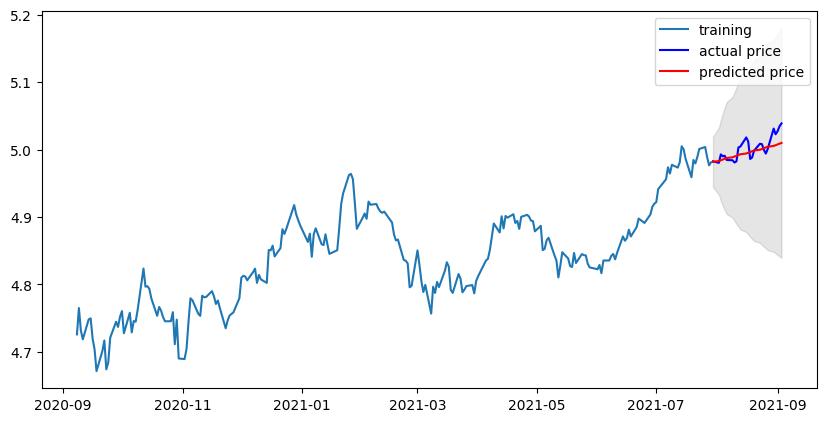

In [33]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  4.034801430412081
MAE:  1.5856051803061735
RMSE:  2.0086815154254993
MAPE: 1.05%


----
# 프로젝트 정리

![image](https://user-images.githubusercontent.com/84179578/132312328-427ae9a3-e40e-4d7f-b894-3f3947569319.png)

결과적으로 삼성전자와 애플의 주식을 예측해본 결과 MAPE 값은 각 각 4.68% (삼성전자), 1.05% (애플) 정도의 오차율을 보이는 것을 확인하였다.  

전체적으로 괜찮은 정확도로 예측을 할 수 있었던 이유는 데이터가 비교적 단순한 형태를 가지고 있고, 잘 정제 되어 있는 데이터를 사용했기 때문임을 예상 할 수 있다.   

삼성 전자와 애플 과 오차율에서 차이가 나는 이유는 애플의 경우, 전체적으로 일관적인 상향 흐름을 가지고 있는 반면, 삼성 전자의 경우 상향 흐름을 가지고 있다가 후반 부분 부터 보이는 갑작스런 하향 흐름 때문임을 예상 할 수 있다.